In [21]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import nltk
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
 
ps = PorterStemmer()

# Data Reading and PreProcessing

In [22]:
df = pd.read_csv('spam.csv')
df.head()

,Label,EmailText
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [23]:
encoder = LabelEncoder()
df['Label'] = encoder.fit_transform(df['Label'])
df = df.drop_duplicates(keep='first')

In [24]:
def get_importantFeatures(sent):
    sent = sent.lower()
    
    returnList = []
    sent = nltk.word_tokenize(sent)
    for i in sent:
        if i.isalnum():
            returnList.append(i)
    return returnList
 
def removing_stopWords(sent):
    returnList = []
    for i in sent:
        if i not in nltk.corpus.stopwords.words('english') and i not in string.punctuation:
            returnList.append(i)
    return returnList
 
def potter_stem(sent):
    returnList = []
    for i in sent:
        returnList.append(ps.stem(i))
    return " ".join(returnList)

In [25]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from string import punctuation

# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

def process_sentence(sent):
    # Convert to lowercase
    sent = sent.lower()
    
    # Tokenize
    tokens = nltk.word_tokenize(sent)
    
    # Initialize necessary NLTK tools once
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()
    
    # Filter tokens: alphanumeric and not a stopword
    filtered_tokens = [token for token in tokens if token.isalnum() and token not in stop_words and token not in punctuation]
    
    # Stem the filtered tokens
    stemmed_tokens = [ps.stem(token) for token in filtered_tokens]
    
    # Join the stemmed tokens back into a single string
    return " ".join(stemmed_tokens)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/saikirannandipati/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saikirannandipati/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
df['imp_feature'] = df['EmailText'].apply(process_sentence)


# Model Development

In [27]:
from sklearn.model_selection import train_test_split
X = df['imp_feature']
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [28]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix



# Define the parameter grid for GridSearchCV
tuned_parameters = {
    'clf__kernel': ['linear', 'rbf'],
    'clf__gamma': [1e-3, 1e-4, 1e-5],
    'clf__C': [1, 10, 100, 1000, 10000]
}

# Create a pipeline that combines the TfidfVectorizer, potential standard scaling, and the SVM classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    #('scaler', StandardScaler(with_mean=False)),  # Uncomment if you want to scale features
    ('clf', SVC())
])

# Define multiple scorers for evaluation
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1_score': make_scorer(f1_score, average='weighted')
}

# Initialize GridSearchCV with Stratified K-Folds cross-validation and multiple evaluation metrics
grid_search = GridSearchCV(pipeline, tuned_parameters, scoring=scorers, refit='f1_score',
                           cv=StratifiedKFold(n_splits=5), n_jobs=-1, verbose=2)

# Fit the model with training data
grid_search.fit(X_train, y_train)

# Output the best parameters and best score
print(f"Best parameters set found on development set: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")



Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/saikirannandipati/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saikirannandipati/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saikirannandipati/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/saikirannandipati/anacon

Best parameters set found on development set: {'clf__C': 1000, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}
Best score: 0.9831340782015932


# Model Evaluation

In [29]:
# lets see the detailed classification report
print("Detailed classification report:")
y_true, y_pred = y_test, grid_search.predict(X_test)
print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(f"Precision: {precision_score(y_true, y_pred, average='weighted')}")
print(f"Recall: {recall_score(y_true, y_pred, average='weighted')}")
print(f"F1 Score: {f1_score(y_true, y_pred, average='weighted')}")


Detailed classification report:
Accuracy: 0.9814385150812065
Precision: 0.9813072787249861
Recall: 0.9814385150812065
F1 Score: 0.9811338980717045


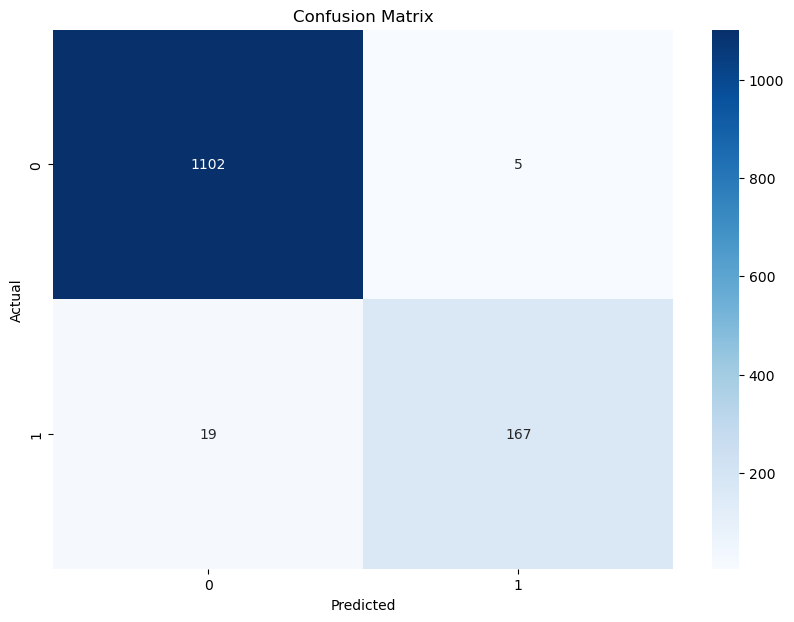

In [30]:
# visualizing with confusion matrix confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report

conf_mat = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_true), yticklabels=set(y_true))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Detailed classification report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1107
           1       0.97      0.90      0.93       186

    accuracy                           0.98      1293
   macro avg       0.98      0.95      0.96      1293
weighted avg       0.98      0.98      0.98      1293



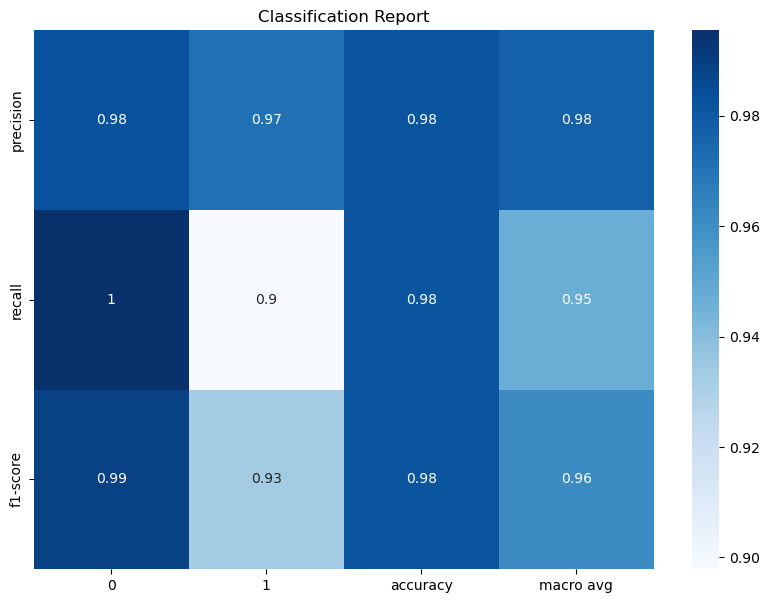

In [31]:

# lets visualize the classification report
report = classification_report(y_true, y_pred, zero_division=0)
print("Detailed classification report:")
print(report)

# Convert classification report to DataFrame for visualization
report_dict = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report_dict).transpose()

# Plot the classification report
plt.figure(figsize=(10, 7))
sns.heatmap(report_df.iloc[:-1, :-1].T, annot=True, cmap='Blues')
plt.title('Classification Report')
plt.show()

In [32]:
# saving the model

import pickle

with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(grid_search.best_estimator_.named_steps['tfidf'], f)

with open('finalized_model.sav', 'wb') as f:
    pickle.dump(grid_search.best_estimator_.named_steps['clf'], f)



In [33]:
# lets build a spam detector app and test our model..

# GUI App

In [34]:
import tkinter as tk
from tkinter import StringVar
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

class SpamDetectorApp:
    def __init__(self, master):
        self.master = master
        master.title("SMS Spam Detector")
        master.geometry("400x600")
        master.configure(background="cyan")
        
        # Load the saved TF-IDF vectorizer and SVM model
        with open("tfidf_vectorizer.pkl", 'rb') as f:
            self.tfidf_vectorizer = pickle.load(f)
        
        with open("finalized_model.sav", 'rb') as f:
            self.spam_model = pickle.load(f)

        self.title_label = tk.Label(master, text="SMS Spam Detector", bg="gray", width="300", height="2",
                                    fg="white", font=("Calibri", 20, "bold", "italic", "underline"))
        self.title_label.pack()

        self.spam_text_label = tk.Label(master, text="Enter your Text:", bg="cyan", font=("Verdana", 12))
        self.spam_text_label.place(x=12, y=100)

        self.spam_text_entry = tk.Entry(master, width=33)
        self.spam_text_entry.place(x=155, y=105)

        self.my_string_var = StringVar()
        self.my_string_var.set("Result:")

        self.result_label = tk.Label(master, textvariable=self.my_string_var, bg="cyan", font=("Verdana", 12))
        self.result_label.place(x=12, y=200)

        self.submit_button = tk.Button(master, text="Submit", width=12, height=1, activebackground="red", bg="Pink",
                                       command=self.check_spam, font=("Verdana", 12))
        self.submit_button.place(x=12, y=150)

    def check_spam(self):
        text = self.spam_text_entry.get()
        transformed_text = self.tfidf_vectorizer.transform([text])
        is_spam = self.spam_model.predict(transformed_text)[0]  # Use [0] to get the prediction from array
        if is_spam == 1:
            print("Text is spam")
            self.my_string_var.set("Result: Text is spam")
        else:
            print("Text is not spam")
            self.my_string_var.set("Result: Text is not spam")

if __name__ == "__main__":
    root = tk.Tk()
    app = SpamDetectorApp(root)
    root.mainloop()


Text is not spam
